# 2) Nested cross-validation 

This notebook shows the use of cross-validation to tune hyperparameters for classifiers

See also the documentation of scikit-learn library (https://scikit-learn.org/)

In [22]:
# import librairies

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 18}
mpl.rc('font', **font)

## Generate samples to classify

We first generate synthetic data with 2 classes to separate (`s0` and `s1` samples, respectively). The input dimensionality corresponds `m` features.

In [2]:
# create synthetic dataset where 2 classes of s0+s1 samples of m-dimensional inputs with controlled contrast
def gen_inputs(m,        # input dimensionality
               s0,       # number of samples for class 0
               s1,       # number of samples for class 1
               scaling): # scaling factor to separate classes

    # labels
    lbl = np.zeros([s0+s1], dtype=int)
    # inputs
    X = np.zeros([s0+s1,m])

    # create s0 and s1 samples for the 2 classes
    for i in range(s0+s1):
        # label
        lbl[i] = int(i<s0)
        # inputs are random noise plus a shift
        for j in range(m):
            # positive/negative shift for 1st/2nd class
            if i<s0:
                a = -scaling
            else:
                a = scaling
            # the shift linearly depends on the feature index j
            X[i,j] = a*j/m + np.random.randn()
            
    return X, lbl

In [3]:
# generate inputs and labels
m = 50 # input dimensionality
s0=100 # number of samples for class 0
s1=100 # number of samples for class 1
X, y = gen_inputs(m, s0, s1, scaling=0.2)

## Parameterization of classifier

We then choose a classifier and a cross-validation scheme.

In [4]:
# (multinomial) logistic regression, involving regularization controlled by the hyperparameter C
clf_MLR = LogisticRegression(C=10000.0, penalty='l2', solver='lbfgs', max_iter=500)

# repetitions of cross-validation (train-test)
n_rep = 5
# stratified K fold with (same splitting with 80% for training and 20% for testing as StratifiedShuffleSplit before)
cvs = StratifiedKFold(n_splits=n_rep)

### Role of hyperparameter

What is the effect of the hyperparameter C that governs the regularization?

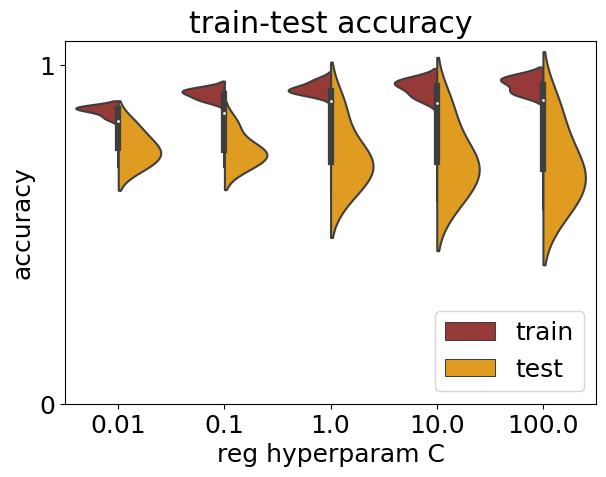

In [7]:
# grid evaluation (log scale)
Cs = np.array([0.01,0.1,1.0,10.0,100.0])
n_C = Cs.size

acc = pd.DataFrame(columns=['type', 'C', 'score'])

# repeat classification
for train_ind, test_ind in cvs.split(X, y):
    # loop over hyperparameter
    for C in Cs:
        # set regularization
        clf_MLR.set_params(C=C)
        # train classifier
        clf_MLR.fit(X[train_ind,:], y[train_ind])
        d = {'type': ['train'],
             'C': [C], 
             'score': [clf_MLR.score(X[train_ind,:], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)))
        # test classifier       
        d = {'type': ['test'],
             'C': [C], 
             'score': [clf_MLR.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)))


# plot
sb.violinplot(data=acc, x='C', y='score', hue='type', split=True, scale='width', palette=['brown','orange'])
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.xlabel('reg hyperparam C')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title('train-test accuracy')
plt.show()

The hyperparameter `C` has opposing effects on the train and test accuracies. This indicates that the unregularized MLR classifier (with large `C`) is overfitting the data here. 

How to select the best value for `C`?

## Inner cross-validation loop within the training set

We can use cross-validation within the training set to test the effec tof `C`. Of course this reduces the amount of data for training within the original training set.

In [8]:
# nested cross-validation scheme
n_split_nest = 5
cv_nest = StratifiedKFold(n_splits=n_split_nest)

# indices of splits
ind_split_inner = np.zeros([n_rep*n_split_nest,s0+s1])
ind_split_outer = np.zeros([n_rep,s0+s1])

# outer loop
i_inner = 0
i_outer = 0
for tr_ind, test_ind in cvs.split(X, y):
    # split data
    X_tr, X_test = X[tr_ind,:], X[test_ind,:]
    y_tr, y_test = y[tr_ind], y[test_ind]
    
    # 2=train+val, 3=test
    ind_split_outer[i_outer, tr_ind] = 2
    ind_split_outer[i_outer, test_ind] = 3

    # inner loop
    for train_ind, val_ind in cv_nest.split(X_tr, y_tr):
        # 0=train, 1=val, 3=test
        ind_split_inner[i_inner, tr_ind[val_ind]] = 1
        ind_split_inner[i_inner, test_ind] = 3
        # increase counter
        i_inner += 1
        
    # increase counter
    i_outer += 1

Let's first look at the splits in the outer loop.

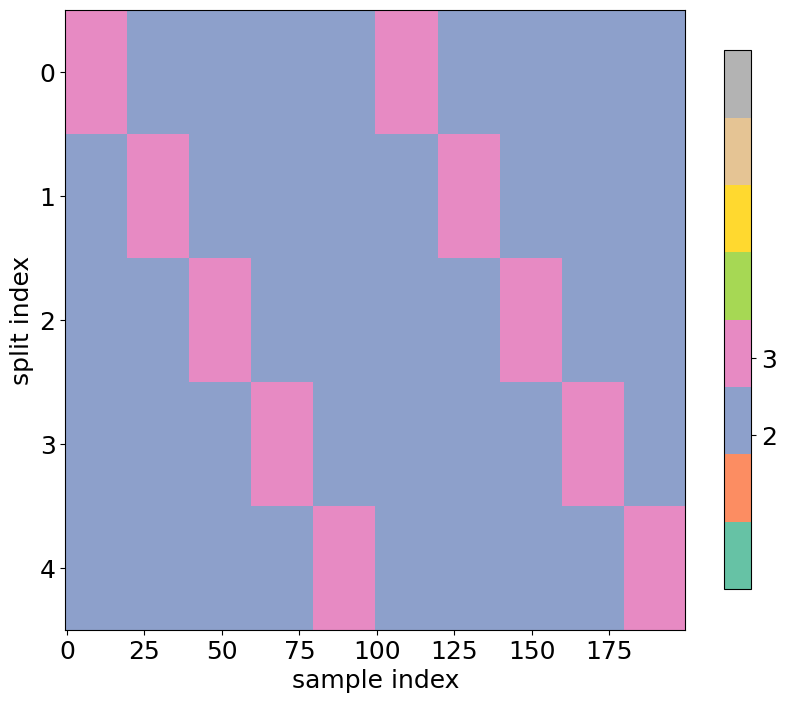

In [9]:
# plot split indices for each 
plt.figure(figsize=[10,10])
plt.imshow(ind_split_outer, vmin=0, vmax=7, cmap='Set2', interpolation='nearest', aspect=40)
plt.xlabel('sample index')
plt.ylabel('split index')
plt.colorbar(ticks=[2,3], shrink=0.7)
plt.show()

For each split, we subdivide the outer "training" set, into the inner training and validation sets.

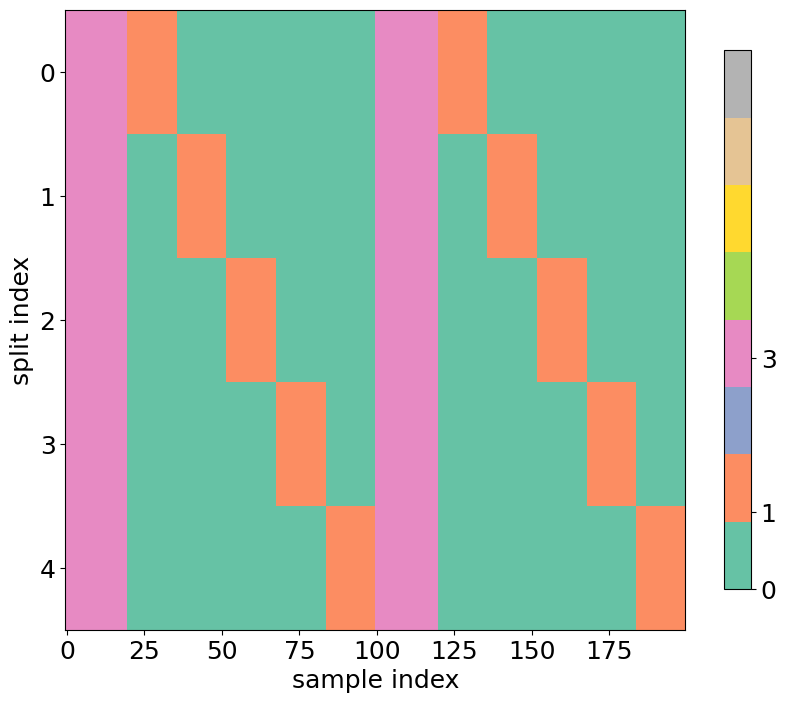

In [10]:
# plot split indices
plt.figure(figsize=[10,10])
plt.imshow(ind_split_inner[:n_split_nest,:], vmax=7, cmap='Set2', interpolation='nearest', aspect=40)
plt.xlabel('sample index')
plt.ylabel('split index')
plt.colorbar(ticks=[0,1,3], shrink=0.7)
plt.show()

Putting everything together, we have the 3 sets

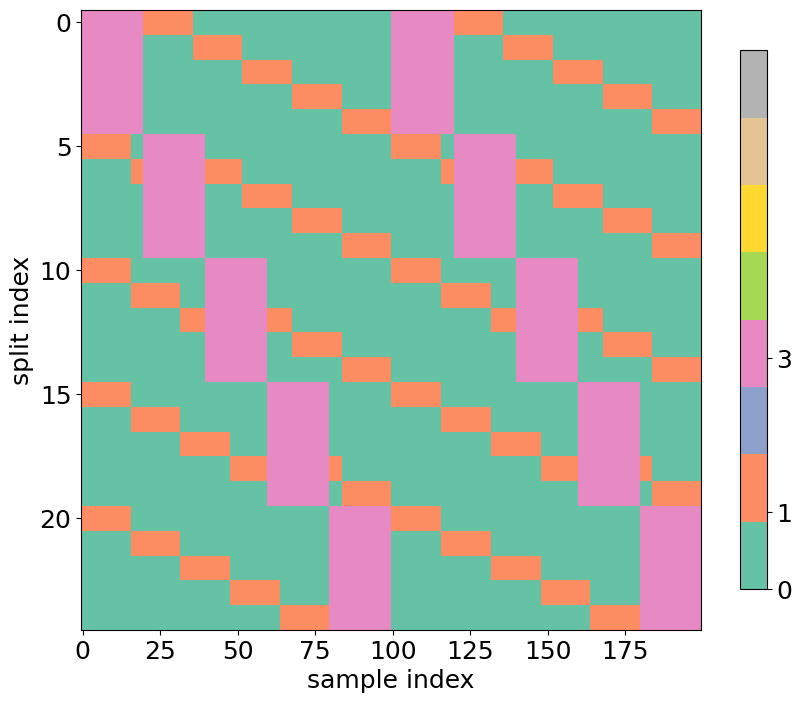

In [11]:
# plot split indices
plt.figure(figsize=[10,10])
plt.imshow(ind_split_inner, vmax=7, cmap='Set2', interpolation='nearest', aspect=8)
plt.xlabel('sample index')
plt.ylabel('split index')
plt.colorbar(ticks=[0,1,3], shrink=0.7)
plt.show()

We can do the same with any outer loop, like the `StratifiedShuffleSplit` that we used before.

TypeError: Colorbar.__init__() got an unexpected keyword argument 'xlabel'

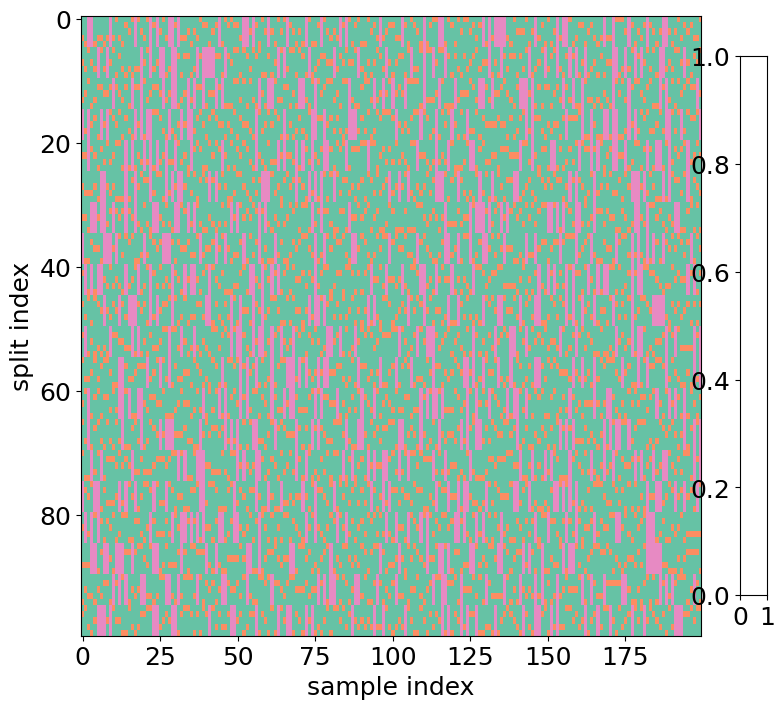

In [14]:
# change outer cross-validation scheme
n_rep = 20
cvs = StratifiedShuffleSplit(n_splits=n_rep, test_size=0.2)

# indices of splits
ind_split = np.zeros([n_rep*n_split_nest,s0+s1])

# outer loop
i_rep = 0
for train_ind, test_ind in cvs.split(X, y):
    # split data
    X_train, X_test = X[train_ind,:], X[test_ind,:]
    y_train, y_test = y[train_ind], y[test_ind]
    
    # inner loop
    for tr_ind, val_ind in cv_nest.split(X_train, y_train):
        ind_split[i_rep, train_ind[val_ind]] = 1
        ind_split[i_rep, test_ind] = 3
        i_rep += 1

# plot split indices
plt.figure(figsize=[10,10])
plt.imshow(ind_split, vmax=7, cmap='Set2', interpolation='nearest', aspect=2)
plt.xlabel('sample index')
plt.ylabel('split index')
plt.colorbar(ticks=[0,1,3], xlabel=['train','val','test'], shrink=0.7)
plt.show()

Now we can use this splitting scheme to test the effect of `C`, selecting the value that gives the best accuracy averaged over the validation sets.

In [15]:
# function to train hyperparameter with nested CV
def nested_CV(clf, X, y):
    acc_nest = np.zeros([n_C,n_split_nest])
    j = 0
    for ind0, ind1 in cv_nest.split(X, y):
        # split in train and validation sets
        X0, X1 = X[ind0], X[ind1]
        y0, y1 = y[ind0], y[ind1]
        # train classifier over all reg parameters
        for i, C in enumerate(Cs):
            # set regularization
            clf.set_params(C=C)
            # train classifier on X0
            clf.fit(X0, y0)
            # test classifier on X1
            acc_nest[i,j] = clf.score(X1,y1)
        j += 1
    # get log C parameter
    i_best = np.argmax(acc_nest.mean(1))
    return Cs[i_best]

In [19]:
scalings = [0.1,0.2,0.3,0.4]

acc = pd.DataFrame(columns=['scaling', 'type', 'log C', 'score'])

for scaling in scalings:
    # generate inputs
    X, y = gen_inputs(m, s0, s1, scaling=scaling)
    
    # repeat classification
    for train_ind, test_ind in cvs.split(X, y):
        # select best hyperparameter
        best_C = nested_CV(clf_MLR, X[train_ind,:], y[train_ind])
        clf_MLR.set_params(C=best_C)
        # train and test classifier
        clf_MLR.fit(X[train_ind,:], y[train_ind])
        d = {'scaling': [scaling],
             'type': ['train'],
             'log C': [np.log10(best_C)], 
             'score': [clf_MLR.score(X[train_ind,:], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        d = {'scaling': [scaling],
             'type': ['test'],
             'log C': [np.log10(best_C)], 
             'score': [clf_MLR.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        
        # shuffling
        train_ind_rand = np.random.permutation(train_ind)
    
        best_C = nested_CV(clf_MLR, X[train_ind,:], y[train_ind_rand])
        clf_MLR.set_params(C=best_C)
        clf_MLR.fit(X[train_ind,:], y[train_ind_rand])
        d = {'scaling': [scaling],
             'type': ['shuf'],
             'log C': [np.log10(best_C)], 
             'score': [clf_MLR.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

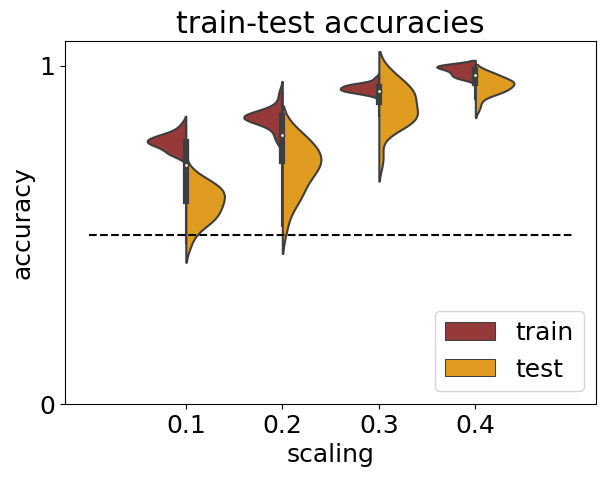

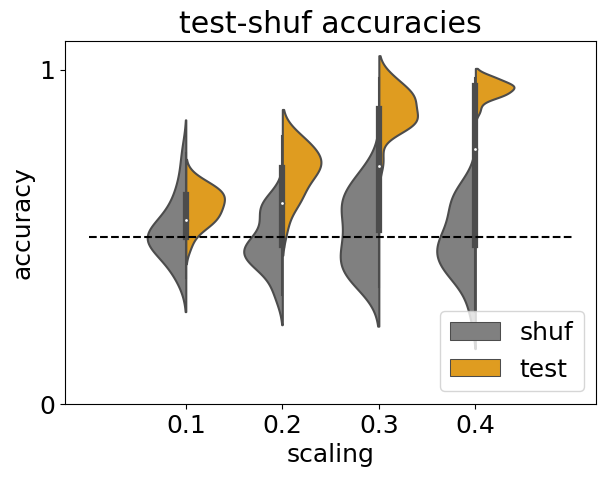

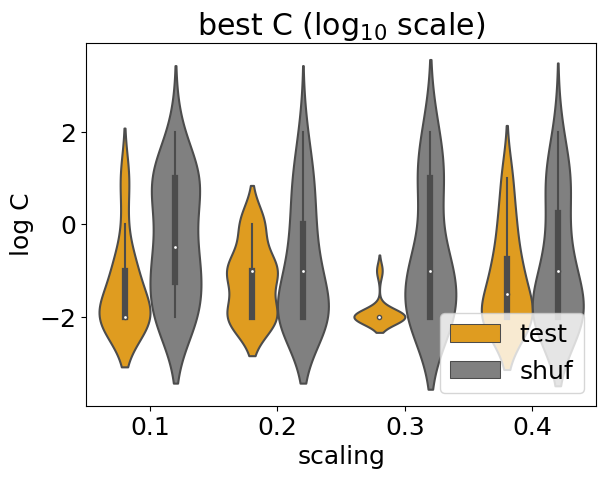

In [20]:
# plots

# theoretical chance level
chance_level = 0.5

acc2 = acc[np.logical_or(acc['type']=='train',acc['type']=='test')]

plt.figure()
sb.violinplot(data=acc2, x='scaling', y='score', hue='type', split=True, 
              palette=['brown','orange'], scale='width')
plt.plot([-1,4], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title('train-test accuracies')


acc2 = acc[np.logical_or(acc['type']=='shuf',acc['type']=='test')]

plt.figure()
sb.violinplot(data=acc2, x='scaling', y='score', hue='type', hue_order=('shuf','test'),
              split=True, palette=['gray','orange'], scale='width')
plt.plot([-1,4], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title('test-shuf accuracies')


plt.figure()
sb.violinplot(data=acc2, x='scaling', y='log C', hue='type', 
              palette=['orange','gray'], scale='width')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title('best C (log$_{10}$ scale)')

plt.show()

We find that the best `C` selected by the nested cross-validation is $0.01$, in line with the comparison of training/testing accuracies at the beginning of the notebook (with the scaling $0.2$ that governs the contrast across the 2 classes). 

Here the scaling affects the selected `C` with looser selection for smaller scaling (i.e. when the classification is difficult and the classifier does not perform well). 

Note that the classifier trained with shuffled labels for the baseline accuracy does not depend on `C`.

## Implementation in scikit-learn

Let's use `GridSearchCV`, which performs the fitting of the parameters.

In [28]:
# grid search for hyperparameter C
gscv = GridSearchCV(clf_MLR,
                    {'C': Cs},
                    cv=cv_nest)

acc = pd.DataFrame(columns=['scaling', 'type', 'log C', 'score'])

for scaling in scalings:
    # generate inputs
    X, y = gen_inputs(m, s0, s1, scaling=scaling)
    
    # repeat classification
    for train_ind, test_ind in cvs.split(X, y):
        # Train and test classifiers with subject labels
        gscv.fit(X[train_ind,:], y[train_ind])
        best_C = nested_CV(clf_MLR, X[train_ind,:], y[train_ind])
        clf_MLR.set_params(C=best_C)
        clf_MLR.fit(X[train_ind,:], y[train_ind])
        d = {'scaling': [scaling],
             'type': ['test'],
             'log C': [np.log10(best_C)], 
             'score': [clf_MLR.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
    
        # shuffling
        train_ind_rand = np.random.permutation(train_ind)
    
        best_C = nested_CV(clf_MLR, X[train_ind,:], y[train_ind_rand])
        clf_MLR.set_params(C=best_C)
        clf_MLR.fit(X[train_ind,:], y_train_rand)
        d = {'scaling': [scaling],
             'type': ['shuf'],
             'log C': [np.log10(best_C)], 
             'score': [clf_MLR.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

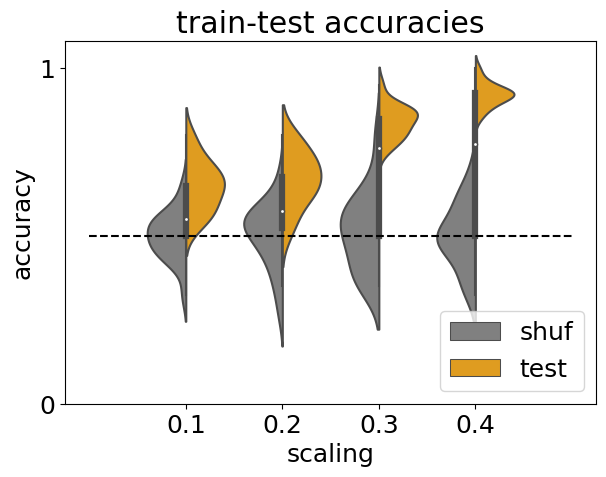

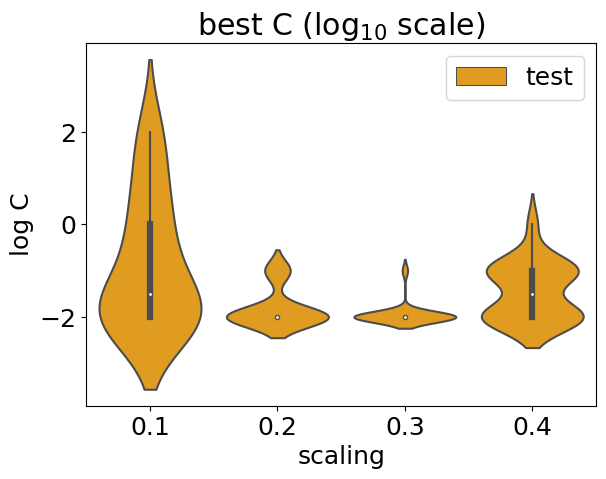

In [29]:
plt.figure()
sb.violinplot(data=acc, x='scaling', y='score', hue='type', hue_order=['shuf','test'], split=True, 
              palette=['gray','orange'], scale='width')
plt.plot([-1,4], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.title('train-test accuracies')


acc2 = acc[acc['type']=='test']

plt.figure()
sb.violinplot(data=acc2, x='scaling', y='log C', hue='type', 
              palette=['orange'], scale='width')
plt.legend(loc='upper right')
plt.tight_layout()
plt.title('best C (log$_{10}$ scale)')

plt.show()